
Reinforcement Learning (DDQN) For the gym Pong enviroment
=====================================
**Author:** `Mads Lyngsaae Nielsen (s147098) & Emilie Isabella Dahl (s153762) <INSERT GITHUB LINK>`_

# **Task:**
To maximize the reward/scorer in the game Pong with Deep Q-Learning (DQN). 

This project is the final part of the course "02456 Deep Learning E19" at DTU F19. 




Initialize notebook
--------

In [1]:
# Add libraries
import os
import gym
import sys
import math
import random
import matplotlib
import numpy as np
from PIL import Image
from pathlib import Path
from itertools import count
from base64 import b64encode
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import namedtuple

# Torch libraries used
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Enviroments
#env = gym.make('Pong-v0').unwrapped
#env = gym.make('PongNoFrameskip-v4'). unwrapped
env = gym.make('PongDeterministic-v4').unwrapped

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Preprocessing 
--------------
Since the observations has a very high dimensionality, because they are images, the dimensionality  should be lowered and the image simplified as much as possible, without losing significant information. This is done by first grayscaling, then cropping and the image with the game part and then finally resizing it.

Since it is impossible to figure out how the balls moving direction from one frame alone, the algorithm stacks the 4 last observations in a tensor, which then is returned and used as the state. This way the network will be able to tell the direction.





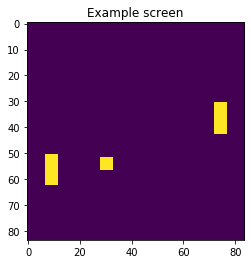

In [3]:
# Preprociing and stacking

resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC),T.ToTensor()])

def get_screen(env):
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # transpose into torch order (CHW)
    screen = np.ascontiguousarray(screen, dtype=np.float32) 
    screen = screen[0, 34:194, :]
    screen[screen == 144]= 0
    # Resize, and add a batch dimension (BCHW)
    screen = resize(screen)
    screen[screen != 0] = 1

    return screen.unsqueeze(0)


def update_state(state, env, done=False):
      current_screen = get_screen(env)
      next_state_update = torch.zeros(state.shape)

      if not done:
          next_state_update[:,1:4,:,:] = state[:,0:3,:,:]
          next_state_update[:,0,:,:] = current_screen 
      else:
          next_state_update = None

      return next_state_update


# Example of the get_screen
env.reset()
for _ in range(20):
  env.step(1)
state = torch.cat((get_screen(env),get_screen(env),get_screen(env),get_screen(env)), dim=1, out=None)
plt.figure()
plt.imshow(state[0,1,:,:].numpy(), interpolation='none')
plt.title('Example screen')
plt.show()


Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.


Furthere more we implement a Prioritized Experience Replay class, where instead of sampling wit ha uniform distribution, we put more weight on signicant events, like failling og winning a point.

In [0]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

def sample_memory(memory, device, non_blocking=False):
    # sample replay buffer
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # convert to tensors and create batches
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device, non_blocking=non_blocking)
    state_batch = torch.cat(batch.state).to(device, non_blocking=non_blocking)
    action_batch = torch.cat(batch.action).to(device, non_blocking=non_blocking)
    reward_batch = torch.cat(batch.reward).to(device, non_blocking=non_blocking)

    return state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states
    

In [0]:
# SumTree - https://github.com/rlcode/per/blob/master/SumTree.py
# a binary tree data structure where the parent’s value is the sum of its children
# Needed for the Prioritized Experience Replay
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [0]:
#Prioritized Experience Replay - https://sergioskar.github.io/Taking_Deep_Q_Networks_a_step_further/
class PER:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    def __init__(self, capacity, discount_factor,  non_blocking=False):
        self.tree = SumTree(capacity)
        self.discount_factor = discount_factor
        self.non_blocking = non_blocking

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, *args):
        p = self._getPriority(error)
        self.tree.add(p, Transition(*args))

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append(data)

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

    def push(self, state, action, reward, next_state, done, model, target_model):
        target = model(state.to(device, non_blocking=self.non_blocking))
        old_val = target[0][action]
        if done:
            target[0][action] = reward
        else:
            target_val = target_model(next_state.to(device, non_blocking=self.non_blocking))
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])
        self.add(error, state, action, next_state, reward)


DQN Definitions
-------------
Here we fine our 2 types of networks. Classic DQN and a dueling DQN.

In [0]:
class DQN(nn.Module):

    def __init__(self, in_channels, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=64*7*7 , out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    # return Q values of each action


class DuelingDQN(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_dim)
        )

    def forward(self, state):
        features = self.conv(state)
        features = features.view(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals



Training
--------
The section we start initializing the hyper parameters, the policy and target network and optimizer.

Further more we define our action selection fuction.

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
.




In [0]:
# Trainin parameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01
MEMORY_SIZE = 10000
EPS_DECAY = 100000 
TARGET_UPDATE = 10000
START_OPTIMIZER = 1000
OPTIMIZE_FREQUENCE = 4
learning_rate = 0.00025

n_actions = 3 #env.action_space.n  # 3 redundant actions - Usefull actiosn 
actions_offset = 1 

# Initializes networks
#policy_net = DQN(4, n_actions).to(device)
#target_net = DQN(4, n_actions).to(device)
policy_net = DuelingDQN(4, n_actions).to(device)
target_net = DuelingDQN(4, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
policy_net.train()
target_net.eval()


optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate)

#memory = ReplayMemory(MEMORY_SIZE)
memory = PER(MEMORY_SIZE, GAMMA)

model_save_name = 'Pong_POLICY.pt'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}"
#torch.save(policy_net.state_dict(), path)

steps_done = 0
i_episode = 0

def select_action(state):
    global steps_done
    sample = random.random()
    if i_episode < 1000: 
      eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
      eps_threshold = 0.001
      
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state.to(device)).max(1)[1].view(1, 1), eps_threshold
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long), eps_threshold

**Define optimize function**

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability.**bold text**


In [0]:
def optimize_model(policy_net, target_net, memory, batch=None):
    #Prepare networks
    policy_net.train()
    target_net.eval()

    #if len(memory) < BATCH_SIZE:
    #    return

    if batch is None:
        batch = sample_memory(memory, device)

    state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states = batch

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Compute expected state action value
    argmax_next_state_values = policy_net(non_final_next_states).argmax(1).detach().unsqueeze(1)
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1,argmax_next_state_values).detach().squeeze()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    # compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.)
    optimizer.step()


**Run training**

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward, and optimize our model once. When the episode ends, we restart the loop.




In [26]:
num_episodes = 2000
loss = list()
state_cuda = []
episode_durations = []
episode_totalRewards = []

for i_episode in range(num_episodes):
    # Initialize the environment and state
    total_reward = 0
    actions = np.zeros((n_actions), dtype = np.int)
    env.reset()
    for j in range(15):
        env.step(env.action_space.sample())

    state = torch.cat((get_screen(env),get_screen(env),get_screen(env),get_screen(env)), dim=1, out=None)
    next_state = state.clone()
  

    for t in count():
        # Select and perform an action
        state_cuda = state.to(device)
        action, threshold = select_action(state_cuda)
        _, reward, done, _ = env.step(action.item()+actions_offset)
        total_reward += reward
        actions[action.item()] += 1

        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = update_state(state, env, done)

        # Store the transition in memory
        #memory.push(state, action, next_state, reward)
        memory.push(state, action, reward, next_state, done, policy_net, target_net)
       
        # Move to the next state
        if next_state is not None:
            state = next_state
        else:
            state = None
        

        # Perform one step of the optimization (on the target network)
        if (steps_done % OPTIMIZE_FREQUENCE == 0) and steps_done > START_OPTIMIZER:
            optimize_model(policy_net, target_net, memory)      
  
        if done:
            episode_durations.append(t + 1)
            episode_totalRewards.append(total_reward)
            break

        # Update the target network
        if steps_done % TARGET_UPDATE == 0 and steps_done > (START_OPTIMIZER +TARGET_UPDATE):
            target_net.load_state_dict(policy_net.state_dict())

    # Print status parameters
    print("Episode number: ", i_episode, " - Total reward: ", total_reward, "Episode duration: ", episode_durations[-1], "Actions: ", actions, "Frames:", steps_done, "Threshold: %.2f" % threshold)

    # Save model
    if i_episode % 100 == 0:
      torch.save(policy_net.state_dict(), path)
      print("Model Saved %d" %(i_episode))
    
    # Clear used cuda memory
    del state_cuda
    torch.cuda.empty_cache()


print('Complete')
env.render()
plt.show()

Episode number:  0  - Total reward:  -21.0 Episode duration:  1078 Actions:  [330 379 369] Frames: 1078 Threshold: 0.99
Model Saved 0
Episode number:  1  - Total reward:  -21.0 Episode duration:  828 Actions:  [286 265 277] Frames: 1906 Threshold: 0.98
Episode number:  2  - Total reward:  -20.0 Episode duration:  887 Actions:  [302 312 273] Frames: 2793 Threshold: 0.97
Episode number:  3  - Total reward:  -21.0 Episode duration:  749 Actions:  [246 230 273] Frames: 3542 Threshold: 0.97
Episode number:  4  - Total reward:  -21.0 Episode duration:  809 Actions:  [260 259 290] Frames: 4351 Threshold: 0.96
Episode number:  5  - Total reward:  -21.0 Episode duration:  809 Actions:  [253 289 267] Frames: 5160 Threshold: 0.95
Episode number:  6  - Total reward:  -21.0 Episode duration:  931 Actions:  [283 338 310] Frames: 6091 Threshold: 0.94
Episode number:  7  - Total reward:  -20.0 Episode duration:  964 Actions:  [305 323 336] Frames: 7055 Threshold: 0.93
Episode number:  8  - Total rewar

KeyboardInterrupt: ignored

**Learning results**

This cell plots the learning curves of the network.

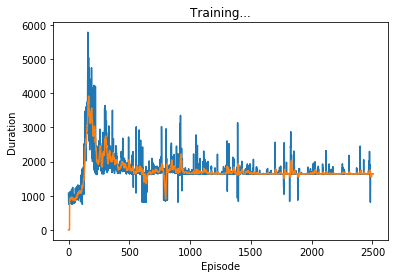

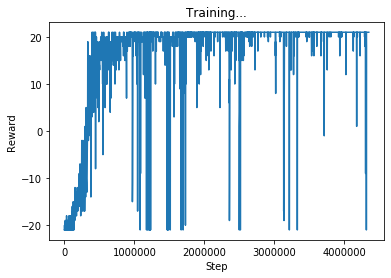

In [39]:
# Plot learning curves
plt.figure(2)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 10:
    means = durations_t.unfold(0, 10, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(3)
rewards_t = torch.tensor(episode_totalRewards, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.plot(np.add.accumulate(durations_t.numpy()), rewards_t.numpy())



**Save model**

In [28]:
# Save model
torch.save(policy_net.state_dict(), path)
print("Model Saved %d" %(i_episode))

Model Saved 2505


Testing
--------
This sections is used to test the DQN and show the resulting mp4 video. 

First we define our test fuction.

In [0]:
# Set up test enviroment functions
def find_files(root, extension):
    for file in os.listdir(root):
        if file.endswith(extension):
          return file

    return None

def test(env, n_episodes, policy, path = F"/videos", render=True):
    env = gym.wrappers.Monitor(env, path, force=True)
    state = torch.cat((get_screen(env),get_screen(env),get_screen(env),get_screen(env)), dim=1, out=None)
    next_state= state.clone()
    for episode in range(n_episodes):
        obs = env.reset()
        total_reward = 0.0
        for t in count():
            state_cuda = state.to(device)
            action = policy(state_cuda).max(1)[1].view(1,1) + actions_offset
            if render:
                env.render()
                time.sleep(0.02)

            obs, reward, done, info = env.step(action)

            total_reward += reward
            state = update_state(state, env, done)
            if done:
                print("Finished Episode {} with reward {}".format(episode, total_reward))
                break

    env.close()
    return

**Test network**

In [30]:
# Test enviroment
video_folder_name = 'Pong_Video'
path_video = F"/content/gdrive/My Drive/Colab Notebooks/{video_folder_name}"

#policy_net = DQN().to(device)
#policy_net.load_state_dict(torch.load(path))
policy_net.eval()

# Run test
test(env, 1, policy_net, path_video, render=False)



Finished Episode 0 with reward 21.0


**Watch test video**

In [32]:
# Extract file name
file = find_files(path_video, 'mp4')
file_path = path_video + '/' + file
print(file)

# Play video
if file is None:
    sys.exit("No video found")

mp4 = open(file_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

openaigym.video.0.146.video000000.mp4
